# ShearNet Model Comparison Notebook  
This notebook compares multiple ShearNet models by loading their saved architectures and evaluating them on the same test dataset.  

**Features:**  
- Loads models from saved `architecture.py` files for comparison of model iterations
- Generates comprehensive comparison plots
- Uses centralized output management system

**Requirements:**  
- `plots/[model_name]/architecture.py` should contain the model class (done automatically)
- Model checkpoints should be in: `model_checkpoint/[model_name]/` (done automatically)
- Loss files should be in: `plots/[model_name]/[model_name]_loss.npz` (done automatically)

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import jax.random as random
import jax.numpy as jnp
import numpy as np
import optax
import os
from dataclasses import dataclass
from typing import List, Optional
import sys
import importlib.util
import re

from shearnet.core.dataset import generate_dataset, split_combined_images
from shearnet.config.config_handler import Config

from flax.training import checkpoints, train_state
from shearnet.utils.metrics import eval_model, eval_ngmix, eval_mcal, remove_nan_preds_multi

from shearnet.utils.plot_helpers import (
    plot_residuals, 
    visualize_samples, 
    plot_true_vs_predicted, 
    animate_model_epochs
)

from shearnet.utils.notebook_output_system import (
    log_print, save_plot, log_array_stats, experiment_section, get_output_manager
)

In [2]:
@dataclass
class ModelConfig:
    """Configuration for a ShearNet model to compare"""
    name: str  # Display name for plots
    model_dir_prefix: str  # Directory prefix to search for (e.g., 'cnn1', 'cnn2')
    color: str  # Color for plots
    marker: str = 'o'  # Marker style for scatter plots

def load_model_from_architecture(model_config, rng_key, test_galaxy_images, test_psf_images, test_labels, base_checkpoint_path, base_data_path):
    """Load a model using its saved architecture.py file and evaluate it"""
    # Path to the saved architecture file
    arch_file = os.path.join(base_data_path, "plots", model_config.model_dir_prefix, "architecture.py")

    config_file = os.path.join(base_data_path, "plots", model_config.model_dir_prefix, "training_config.yaml")

    if not os.path.exists(arch_file):
        raise FileNotFoundError(f"Architecture file not found: {arch_file}")

    if not os.path.exists(config_file):
        raise FileNotFoundError(f"Config file not found: {config_file}")

    log_print(f"Loading architecture from: {arch_file}")
    log_print(f"Loading config from: {config_file}")

    # Load the training configuration
    config = Config(config_file)
    nn_type = config.get('model.type')
    galaxy_type = config.get('model.galaxy.type')
    psf_type = config.get('model.psf.type')
    process_psf = config.get('model.process_psf', False)

    log_print(f"Model type: {nn_type}")
    log_print(f"Galaxy type: {galaxy_type}")
    log_print(f"PSF type: {psf_type}")
    log_print(f"Process PSF: {process_psf}")
    
    # Dynamically import the architecture module
    spec = importlib.util.spec_from_file_location(f"{model_config.model_dir_prefix}_arch", arch_file)
    arch_module = importlib.util.module_from_spec(spec)
    sys.modules[f"{model_config.model_dir_prefix}_arch"] = arch_module
    spec.loader.exec_module(arch_module)

    # Get the appropriate model class from the loaded architecture
    if nn_type == "mlp":
        model = arch_module.SimpleGalaxyNN()
    elif nn_type == "cnn":
        model = arch_module.EnhancedGalaxyNN()
    elif nn_type == "resnet":
        model = arch_module.GalaxyResNet()
    elif nn_type == "research_backed":
        model = arch_module.ResearchBackedGalaxyResNet()
    elif nn_type == "forklens_psfnet":
        model = arch_module.ForkLensPSFNet()
    elif nn_type == "fork-like":
        model = arch_module.ForkLike(galaxy_model_type=galaxy_type, psf_model_type=psf_type)
    else:
        raise ValueError(f"Invalid model type specified: {nn_type}")

    log_print(f"Successfully loaded model: {type(model).__name__}")

    # Initialize model parameters
    if nn_type == "fork-like":
        init_params = model.init(rng_key, jnp.ones_like(test_galaxy_images[0]), jnp.ones_like(test_psf_images[0]))
    else:
        init_params = model.init(rng_key, jnp.ones_like(test_galaxy_images[0]))
    
    state = train_state.TrainState.create(
        apply_fn=model.apply, params=init_params, tx=optax.adam(1e-3)
    )
    
    prefix = re.escape(model_config.model_dir_prefix)
    pattern = f"^{prefix}(?:[0-9]|$)"

    # Get all directories first
    all_dirs = [
        d for d in os.listdir(base_checkpoint_path) 
        if os.path.isdir(os.path.join(base_checkpoint_path, d))
    ]

    # Apply precise matching
    matching_dirs = [
        d for d in all_dirs
        if re.match(pattern, d)
    ]

    # Debug logging
    log_print(f"All directories: {all_dirs}")
    log_print(f"Pattern used: {pattern}")
    log_print(f"Found {len(matching_dirs)} matching directories for {model_config.name}: {matching_dirs}")
    
    if not matching_dirs:
        raise FileNotFoundError(f"No directory found for {model_config.name} with prefix: {model_config.model_dir_prefix}")
    
    # Use the latest directory if multiple found
    model_dir = os.path.join(base_checkpoint_path, sorted(matching_dirs)[-1])
    log_print(f"Loading {model_config.name} from: {model_dir}")
    
    # Restore checkpoint
    state = checkpoints.restore_checkpoint(ckpt_dir=model_dir, target=state)
    log_print("Model checkpoint loaded successfully.")
    
    # Determine input format for evaluation
    if nn_type == "fork-like":
        # For fork-like models, we need to pass galaxy and PSF images separately
        results = eval_model_fork_like(state, test_galaxy_images, test_psf_images, test_labels)
    else:
        # For regular models, use combined images
        results = eval_model(state, test_galaxy_images, test_labels)
    
    return results, config

def eval_model_fork_like(state, galaxy_images, psf_images, labels, batch_size=32):
    """Evaluate fork-like models that take separate galaxy and PSF inputs"""
    import time
    from shearnet.utils.metrics import loss_fn_eval
    
    start_time = time.time()
    total_loss = 0
    total_samples = 0
    total_bias = 0
    
    # Initialize per-label accumulators
    total_loss_per_label = {
        'g1': 0, 'g2': 0, 'g1g2_combined': 0, 'sigma': 0, 'flux': 0
    }
    total_bias_per_label = {
        'g1': 0, 'g2': 0, 'g1g2_combined': 0, 'sigma': 0, 'flux': 0
    }
    
    all_preds = []
    for i in range(0, len(galaxy_images), batch_size):
        batch_galaxy = galaxy_images[i:i + batch_size]
        batch_psf = psf_images[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]
        
        # Get predictions
        preds = state.apply_fn(state.params, batch_galaxy, batch_psf, deterministic=True)
        all_preds.append(preds)
        
        # Calculate loss
        loss = optax.l2_loss(preds, batch_labels).mean()
        batch_bias = (preds - batch_labels).mean()
        batch_size_actual = len(batch_galaxy)
        
        # Accumulate metrics
        total_loss += loss * batch_size_actual
        total_bias += batch_bias * batch_size_actual
        total_samples += batch_size_actual
        
        # Per-label metrics
        loss_per_label = {
            'g1': optax.l2_loss(preds[:, 0], batch_labels[:, 0]).mean(),
            'g2': optax.l2_loss(preds[:, 1], batch_labels[:, 1]).mean(),
            'g1g2_combined': optax.l2_loss(preds[:, :2], batch_labels[:, :2]).mean(),
            'sigma': optax.l2_loss(preds[:, 2], batch_labels[:, 2]).mean(),
            'flux': optax.l2_loss(preds[:, 3], batch_labels[:, 3]).mean()
        }
        
        bias_per_label = {
            'g1': (preds[:, 0] - batch_labels[:, 0]).mean(),
            'g2': (preds[:, 1] - batch_labels[:, 1]).mean(),
            'g1g2_combined': (preds[:, :2] - batch_labels[:, :2]).mean(),
            'sigma': (preds[:, 2] - batch_labels[:, 2]).mean(),
            'flux': (preds[:, 3] - batch_labels[:, 3]).mean()
        }
        
        for label in total_loss_per_label:
            total_loss_per_label[label] += loss_per_label[label] * batch_size_actual
            total_bias_per_label[label] += bias_per_label[label] * batch_size_actual

    # Calculate averages
    avg_loss = total_loss / total_samples
    avg_bias = total_bias / total_samples
    
    avg_loss_per_label = {
        label: total / total_samples 
        for label, total in total_loss_per_label.items()
    }
    avg_bias_per_label = {
        label: total / total_samples 
        for label, total in total_bias_per_label.items()
    }
    
    total_time = time.time() - start_time
    
    # Print results
    log_print(f"Mean Squared Error (MSE) from ShearNet: {avg_loss:.6e}")
    log_print(f"Average Bias from ShearNet: {avg_bias:.6e}")
    log_print(f"Time taken: {total_time:.2f} seconds")
    
    log_print("\n=== Per-Label Metrics ===")
    label_names = ['g1', 'g2', 'g1g2_combined', 'sigma', 'flux']
    for label in label_names:
        log_print(f"{label:>15}: MSE = {avg_loss_per_label[label]:.6e}, Bias = {avg_bias_per_label[label]:+.6e}")
    
    return {
        'loss': avg_loss,
        'bias': avg_bias,
        'loss_per_label': avg_loss_per_label,
        'bias_per_label': avg_bias_per_label,
        'all_preds': jnp.concatenate(all_preds) if all_preds else None,
        'time_taken': total_time
    }

## Configuration  
Modify this section to set up your comparison:

In [3]:
# ==============================================================================
# CONFIGURATION: MODIFY THIS TO SET UP YOUR COMPARISON
# ==============================================================================

# Define the models you want to compare
model_configs = [
    ModelConfig(
        name="CNN model",
        model_dir_prefix="dry_run",
        color="blue", 
        marker="s"
    ),
    ModelConfig(
        name="MLP Model",
        model_dir_prefix="dry_run_mlp",
        color="red",
        marker="^"
    ),
    # Add more models here...
    # ModelConfig(
    #     name="Example Model",
    #     model_dir_prefix="example_model",
    #     color="green",
    #     marker="o"
    # ),
]

include_ngmix = False  # Set to True if you want NGMix comparison

# Test dataset parameters
test_samples = 5000
test_seed = 42 

# Print configuration
log_print("="*50)
log_print("BENCHMARK CONFIGURATION", level="HEADER")
log_print("="*50)
log_print(f"Models to compare: {[config.name for config in model_configs]}")
log_print(f"Include NGMix: {include_ngmix}")
log_print(f"Test samples: {test_samples}")
log_print(f"Test seed: {test_seed}")
log_print("="*50)

DEBUG: Current working directory: /home/adfield/ShearNet/notebooks
DEBUG: Found 'notebooks' in current path
DEBUG: Attempting to create directory: /home/adfield/ShearNet/notebooks/out
DEBUG: Directory created/exists: /home/adfield/ShearNet/notebooks/out
DEBUG: Directory is writable: True
DEBUG: Created new output file: /home/adfield/ShearNet/notebooks/out/out.md
ShearNet Output Manager initialized:
  Output directory: /home/adfield/ShearNet/notebooks/out
  Output file: /home/adfield/ShearNet/notebooks/out/out.md
  Directory exists: True
  Can write to directory: True
BENCHMARK CONFIGURATION
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
Models to compare: ['CNN model', 'MLP Model']
Include NGMix: False
Test samples: 5000
Test seed: 42


## Test Dataset Generation

In [4]:
with experiment_section("Test Dataset Generation"):
    rng_key = random.PRNGKey(test_seed)

    # Generate test dataset with PSF processing enabled to get both galaxy and PSF images
    combined_test_images, test_labels, test_obs = generate_dataset(
        test_samples, 0.25, npix=53, scale=0.141, type='gauss', exp='ideal', 
        nse_sd=1e-5, seed=test_seed, process_psf=True, return_obs=True
    )
    
    # Split into separate galaxy and PSF arrays
    test_galaxy_images, test_psf_images = split_combined_images(combined_test_images)
    
    log_print(f"Generated {len(test_galaxy_images)} test samples")
    log_print(f"Galaxy image shape: {test_galaxy_images.shape}")
    log_print(f"PSF image shape: {test_psf_images.shape}")
    log_print(f"Labels shape: {test_labels.shape}")
    
    # Log some array statistics
    log_array_stats("test_galaxy_images", test_galaxy_images)
    log_array_stats("test_psf_images", test_psf_images)
    log_array_stats("test_labels", test_labels)

Test Dataset Generation
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md


ERROR:2025-08-02 19:33:19,235:jax._src.xla_bridge:502: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/adfield/.conda/envs/shearnet_gpu/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 500, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/adfield/.conda/envs/shearnet_gpu/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/adfield/.conda/envs/shearnet_gpu/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: CUDA_ERROR_NOT_INITIALIZED
ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plugins

Generated 5000 test samples
Galaxy image shape: (5000, 53, 53)
PSF image shape: (5000, 53, 53)
Labels shape: (5000, 4)
test_galaxy_images stats: shape=(5000, 53, 53), min=-0.000, max=0.179, mean=0.001, std=0.005
test_psf_images stats: shape=(5000, 53, 53), min=-0.000, max=0.049, mean=0.000, std=0.003
test_labels stats: shape=(5000, 4), min=-0.949, max=4.998, mean=0.870, std=1.389
---


## Learning Curves Comparison

Learning Curves Comparison
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
CNN model:
  Final training loss: 0.169874
  Final validation loss: 0.162779
  Best validation loss: 0.162779 at epoch 10
  Total epochs: 10
MLP Model:
  Final training loss: 0.505641
  Final validation loss: 0.519611
  Best validation loss: 0.519611 at epoch 10
  Total epochs: 10
DEBUG: Attempting to save plot to: /home/adfield/ShearNet/notebooks/out/learning_curves_comparison_20250802_193327.png
SUCCESS: Plot saved to /home/adfield/ShearNet/notebooks/out/learning_curves_comparison_20250802_193327.png (size: 294476 bytes)
![learning_curves_comparison_20250802_193327.png](learning_curves_comparison_20250802_193327.png)


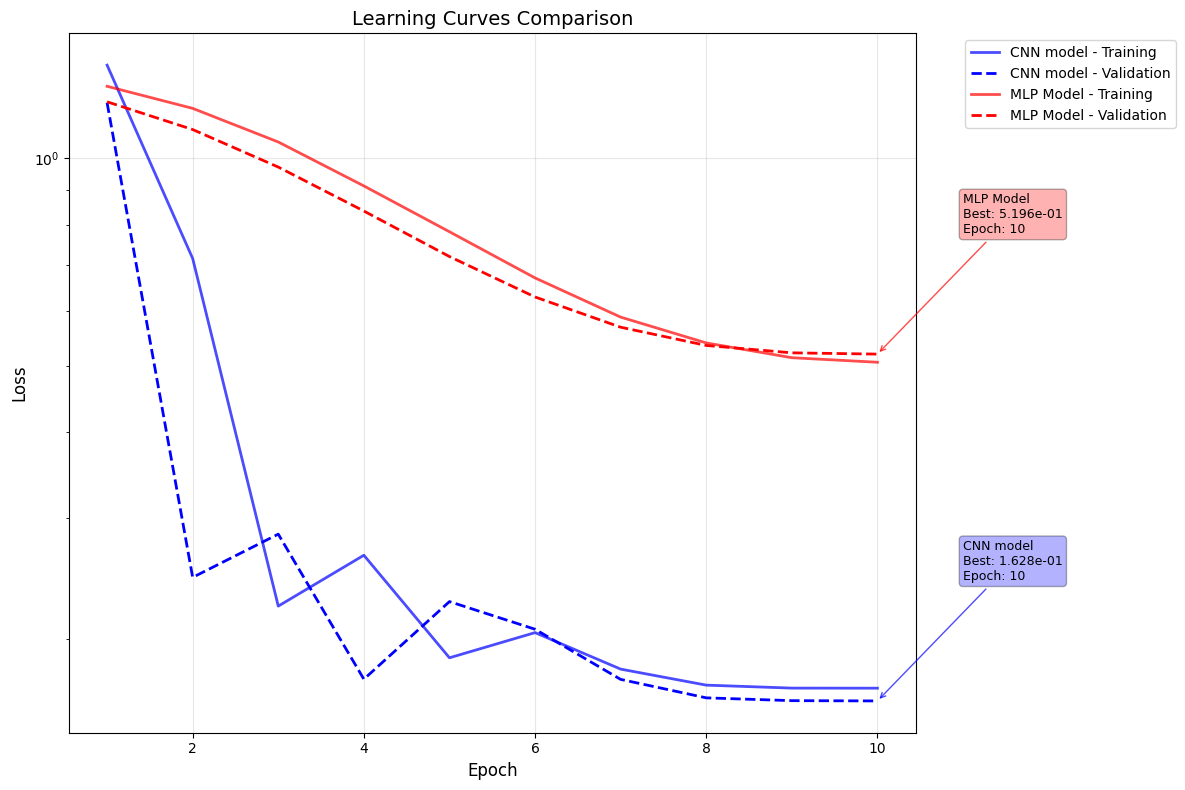

---


In [5]:
with experiment_section("Learning Curves Comparison"):
    base_data_path = os.getenv('SHEARNET_DATA_PATH', os.path.abspath('.'))
    # Create the plot
    plt.figure(figsize=(12, 8))
    for config in model_configs:
        # Load loss data for this model
        loss_file = os.path.join(base_data_path, "plots", config.model_dir_prefix, f"{config.model_dir_prefix}_loss.npz")
        
        if os.path.exists(loss_file):
            loss = np.load(loss_file)
            train_loss = loss['train_loss']
            val_loss = loss['val_loss']
            
            epochs = np.arange(1, len(train_loss) + 1)
            
            # Plot with model-specific colors
            plt.plot(epochs, train_loss, color=config.color, linestyle='-', 
                    label=f'{config.name} - Training', linewidth=2, alpha=0.7)
            plt.plot(epochs, val_loss, color=config.color, linestyle='--', 
                    label=f'{config.name} - Validation', linewidth=2)
            
            # Add annotations for best validation loss
            best_val_epoch = np.argmin(val_loss) + 1
            best_val_loss = np.min(val_loss)
            plt.annotate(f'{config.name}\nBest: {best_val_loss:.3e}\nEpoch: {best_val_epoch}',
                        xy=(best_val_epoch, best_val_loss), 
                        xytext=(best_val_epoch + len(epochs)*0.1, best_val_loss * 1.5),
                        arrowprops=dict(arrowstyle='->', color=config.color, alpha=0.7),
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor=config.color, alpha=0.3))
            
            # Log statistics
            log_print(f"{config.name}:")
            log_print(f"  Final training loss: {train_loss[-1]:.6f}")
            log_print(f"  Final validation loss: {val_loss[-1]:.6f}") 
            log_print(f"  Best validation loss: {best_val_loss:.6f} at epoch {best_val_epoch}")
            log_print(f"  Total epochs: {len(train_loss)}")
        else:
            log_print(f"Warning: Loss file not found for {config.name}: {loss_file}")

    plt.yscale("log")
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Learning Curves Comparison', fontsize=14)
    plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot and show
    save_plot("learning_curves_comparison.png")
    plt.show()

## Model Loading and Evaluation

In [6]:
with experiment_section("Model Loading and Evaluation"):
    base_checkpoint_path = os.path.join(base_data_path, "model_checkpoint")
    # Dictionary to store all results
    all_results = {}
    all_configs = {}
    # Evaluate each ShearNet model
    for model_config in model_configs:
        log_print(f"\nEvaluating {model_config.name}...", level="SUBHEADER")
        try:
            results, config = load_model_from_architecture(
                model_config, rng_key, test_galaxy_images, test_psf_images, 
                test_labels, base_checkpoint_path, base_data_path
            )
            all_results[model_config.name] = {
                'preds': results["all_preds"],
                'config': model_config,
                'results': results,
                'type': 'shearnet'
            }
            all_configs[model_config.name] = config
            log_print(f"Successfully evaluated {model_config.name}")
        except Exception as e:
            log_print(f"Failed to evaluate {model_config.name}: {str(e)}")
            continue

    # Evaluate NGMix if requested
    if include_ngmix:
        log_print(f"\nEvaluating NGMix...", level="SUBHEADER")
        try:
            ngmix_results = eval_ngmix(test_obs, test_labels, seed=1234)
            all_results['NGMix'] = {
                'preds': ngmix_results["preds"],
                'config': None,
                'results': ngmix_results,
                'type': 'ngmix'
            }
            log_print(f"Successfully evaluated NGMix")
        except Exception as e:
            log_print(f"Failed to evaluate NGMix: {str(e)}")

    log_print(f"\nAll evaluations complete! Models: {list(all_results.keys())}")

Model Loading and Evaluation
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md

Evaluating CNN model...
Loading architecture from: /home/adfield/ShearNet/plots/dry_run/architecture.py
Loading config from: /home/adfield/ShearNet/plots/dry_run/training_config.yaml
Model type: cnn
Galaxy type: research_backed
PSF type: forklens_psf
Process PSF: False
Successfully loaded model: EnhancedGalaxyNN
All directories: ['fork-like_1300', 'major_test300', 'dry_run_mlp10', 'dry_run10']
Pattern used: ^dry_run(?:[0-9]|$)
Found 1 matching directories for CNN model: ['dry_run10']
Loading CNN model from: /home/adfield/ShearNet/model_checkpoint/dry_run10
Model checkpoint loaded successfully.

=== Combined Metrics (ShearNet) ===
Mean Squared Error (MSE) from ShearNet: 1.700461e-01
Average Bias from ShearNet: 2.513287e-02
Time taken: 1.02 seconds

=== Per-Label Metrics ===
             g1: MSE = 3.250854e-02, Bias = -3.500990e-03
             g2: MSE = 3.493214e-02, Bias = -1.756443e-02
  g

## Model Evaluation Summary

In [7]:
with experiment_section("Model Evaluation Summary"):
    # True values
    g1_true = test_labels[:, 0]
    g2_true = test_labels[:, 1]  
    sigma_true = test_labels[:, 2]
    flux_true = test_labels[:, 3]

    # Print summary statistics for all models
    log_print("="*60)
    log_print("EVALUATION SUMMARY", level="SUBHEADER")
    log_print("="*60)

    for model_name, result in all_results.items():
        preds = result['preds']
        
        # Remove NaN predictions if any
        if np.any(np.isnan(preds)):
            preds_clean, labels_clean = remove_nan_preds(preds, test_labels)
            log_print(f"\n{model_name} (cleaned {len(test_labels) - len(preds_clean)} NaN predictions):")
        else:
            preds_clean = preds
            labels_clean = test_labels
            log_print(f"\n{model_name}:")
            
        for i, param in enumerate(["g1", "g2", "sigma", "flux"]):
            true_vals = labels_clean[:, i]
            pred_vals = preds_clean[:, i]
            rmse = np.sqrt(np.mean((pred_vals - true_vals)**2))
            bias = np.mean(pred_vals - true_vals)
            log_print(f"  {param:5s}: RMSE = {rmse:.6f}, Bias = {bias:+.6f}")

    log_print(f"\nReady for plotting with {len(all_results)} models")

Model Evaluation Summary
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
EVALUATION SUMMARY

CNN model:
  g1   : RMSE = 0.254984, Bias = -0.003501
  g2   : RMSE = 0.264319, Bias = -0.017564
  sigma: RMSE = 0.287950, Bias = -0.076772
  flux : RMSE = 1.068911, Bias = +0.198369

MLP Model:
  g1   : RMSE = 0.256957, Bias = -0.012839
  g2   : RMSE = 0.266108, Bias = -0.022384
  sigma: RMSE = 0.410409, Bias = +0.182462
  flux : RMSE = 2.012143, Bias = -1.818515

Ready for plotting with 2 models
---


## Prediction Comparison Plots

Prediction Comparison Plots
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
DEBUG: Attempting to save plot to: /home/adfield/ShearNet/notebooks/out/prediction_comparison_20250802_193333.png
SUCCESS: Plot saved to /home/adfield/ShearNet/notebooks/out/prediction_comparison_20250802_193333.png (size: 1335074 bytes)
![prediction_comparison_20250802_193333.png](prediction_comparison_20250802_193333.png)


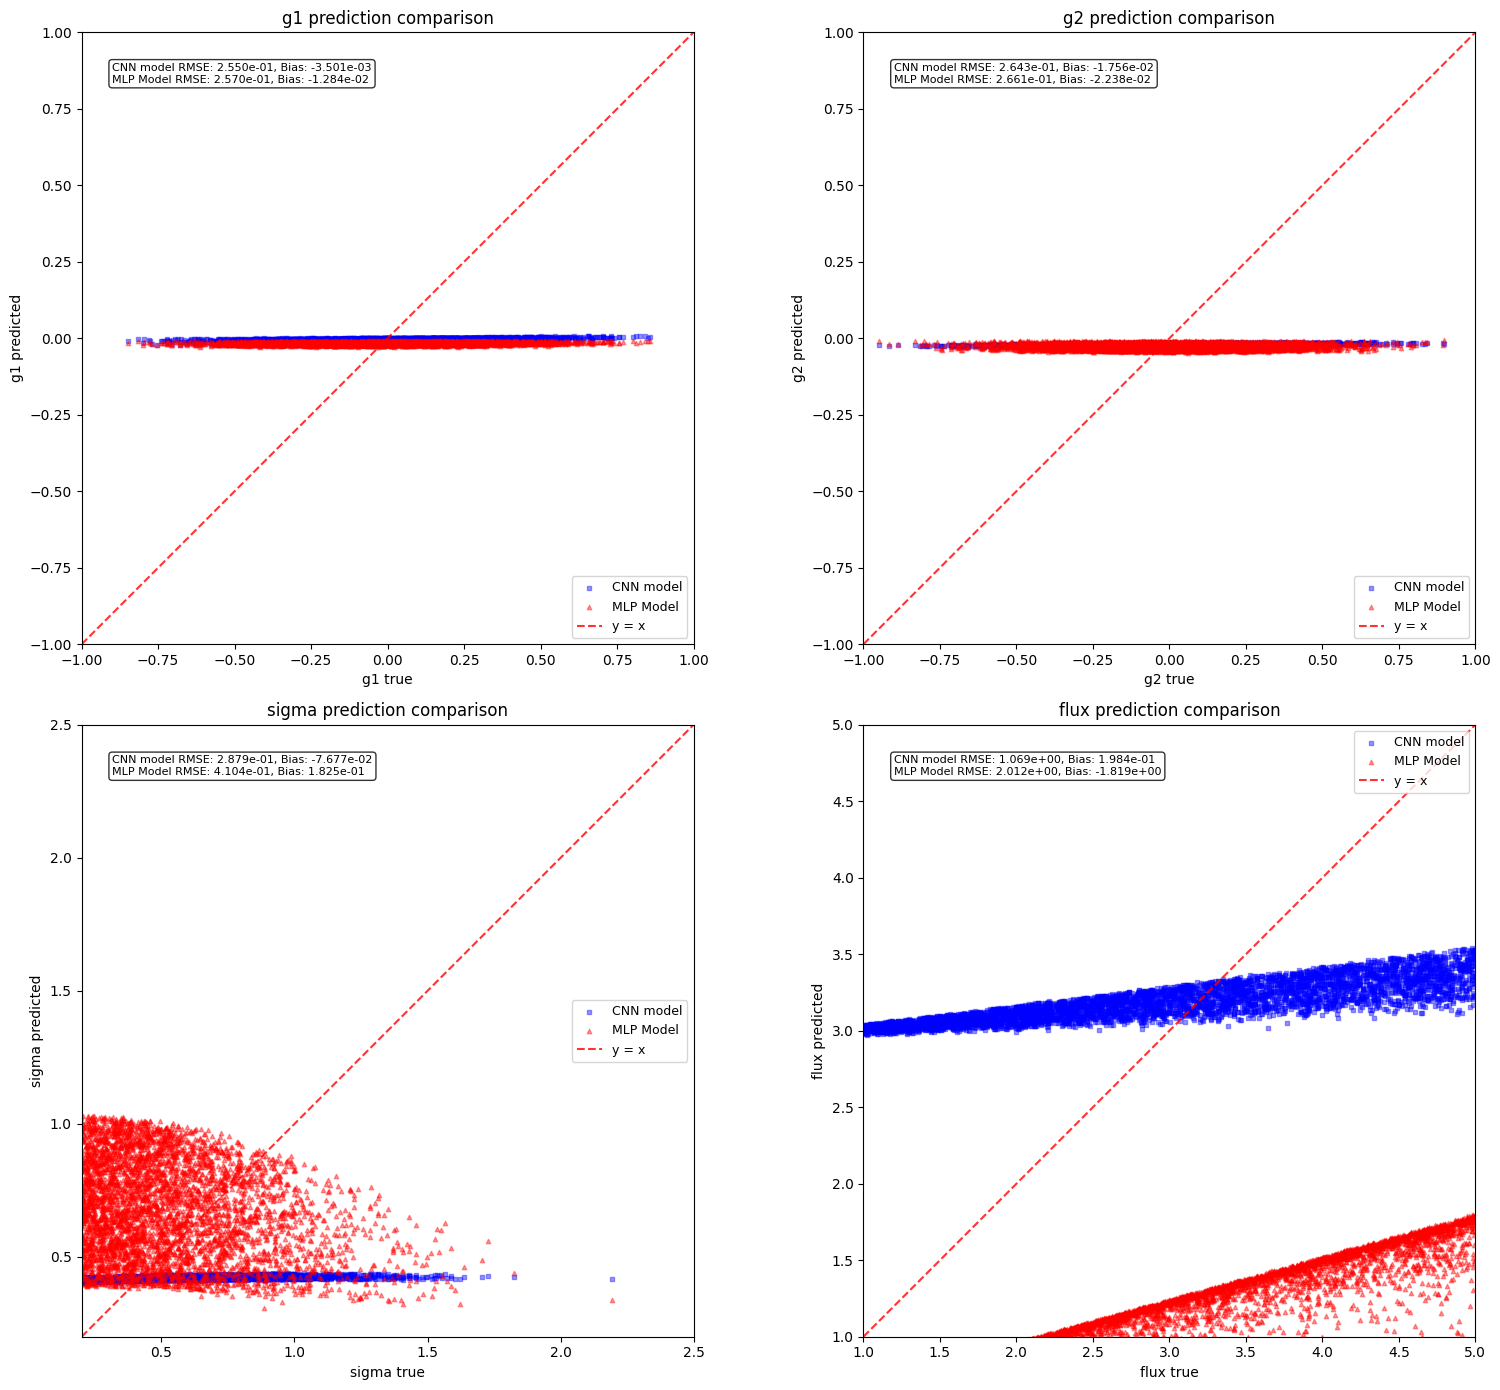

---


In [8]:
with experiment_section("Prediction Comparison Plots"):
    # Set up plot
    fig, axs = plt.subplots(2, 2, figsize=(16, 14))
    quantities = [
        ("g1", g1_true, -1., 1.),
        ("g2", g2_true, -1., 1.),
        ("sigma", sigma_true, 0.2, 2.5),
        ("flux", flux_true, 1, 5.)
    ]
    for ax, (name, true_vals, vmin, vmax) in zip(axs.flat, quantities):
        param_idx = ["g1", "g2", "sigma", "flux"].index(name)
        
        # Plot each model's predictions
        for model_name, result in all_results.items():
            preds = result['preds'][:, param_idx]
            
            if result['type'] == 'ngmix':
                color = 'green'
                marker = '^'
                label = model_name
            else:
                color = result['config'].color
                marker = result['config'].marker
                label = model_name
            
            ax.scatter(true_vals, preds, alpha=0.4, label=label, s=10, 
                      color=color, marker=marker)
        
        # Reference line
        ax.plot([vmin, vmax], [vmin, vmax], 'r--', label='y = x', alpha=0.8)
        
        # Axes formatting
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(vmin, vmax)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel(f"{name} true")
        ax.set_ylabel(f"{name} predicted")
        ax.set_title(f"{name} prediction comparison")

        # Calculate and display metrics
        metrics_text = ""
        for model_name, result in all_results.items():
            preds = result['preds'][:, param_idx]
            rmse = np.sqrt(np.mean((preds - true_vals)**2))
            bias = np.mean(preds - true_vals)
            metrics_text += f"{model_name} RMSE: {rmse:.3e}, Bias: {bias:.3e}\n"

        ax.text(0.05, 0.95, metrics_text.strip(),
                transform=ax.transAxes, fontsize=8,
                verticalalignment='top',
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

        ax.legend(fontsize=9)

    plt.tight_layout()
    
    # Save plot and show
    save_plot("prediction_comparison.png")
    plt.show()

## Residuals Comparison Plots

Residuals Comparison Plots
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
DEBUG: Attempting to save plot to: /home/adfield/ShearNet/notebooks/out/residuals_comparison_20250802_193339.png
SUCCESS: Plot saved to /home/adfield/ShearNet/notebooks/out/residuals_comparison_20250802_193339.png (size: 319598 bytes)
![residuals_comparison_20250802_193339.png](residuals_comparison_20250802_193339.png)


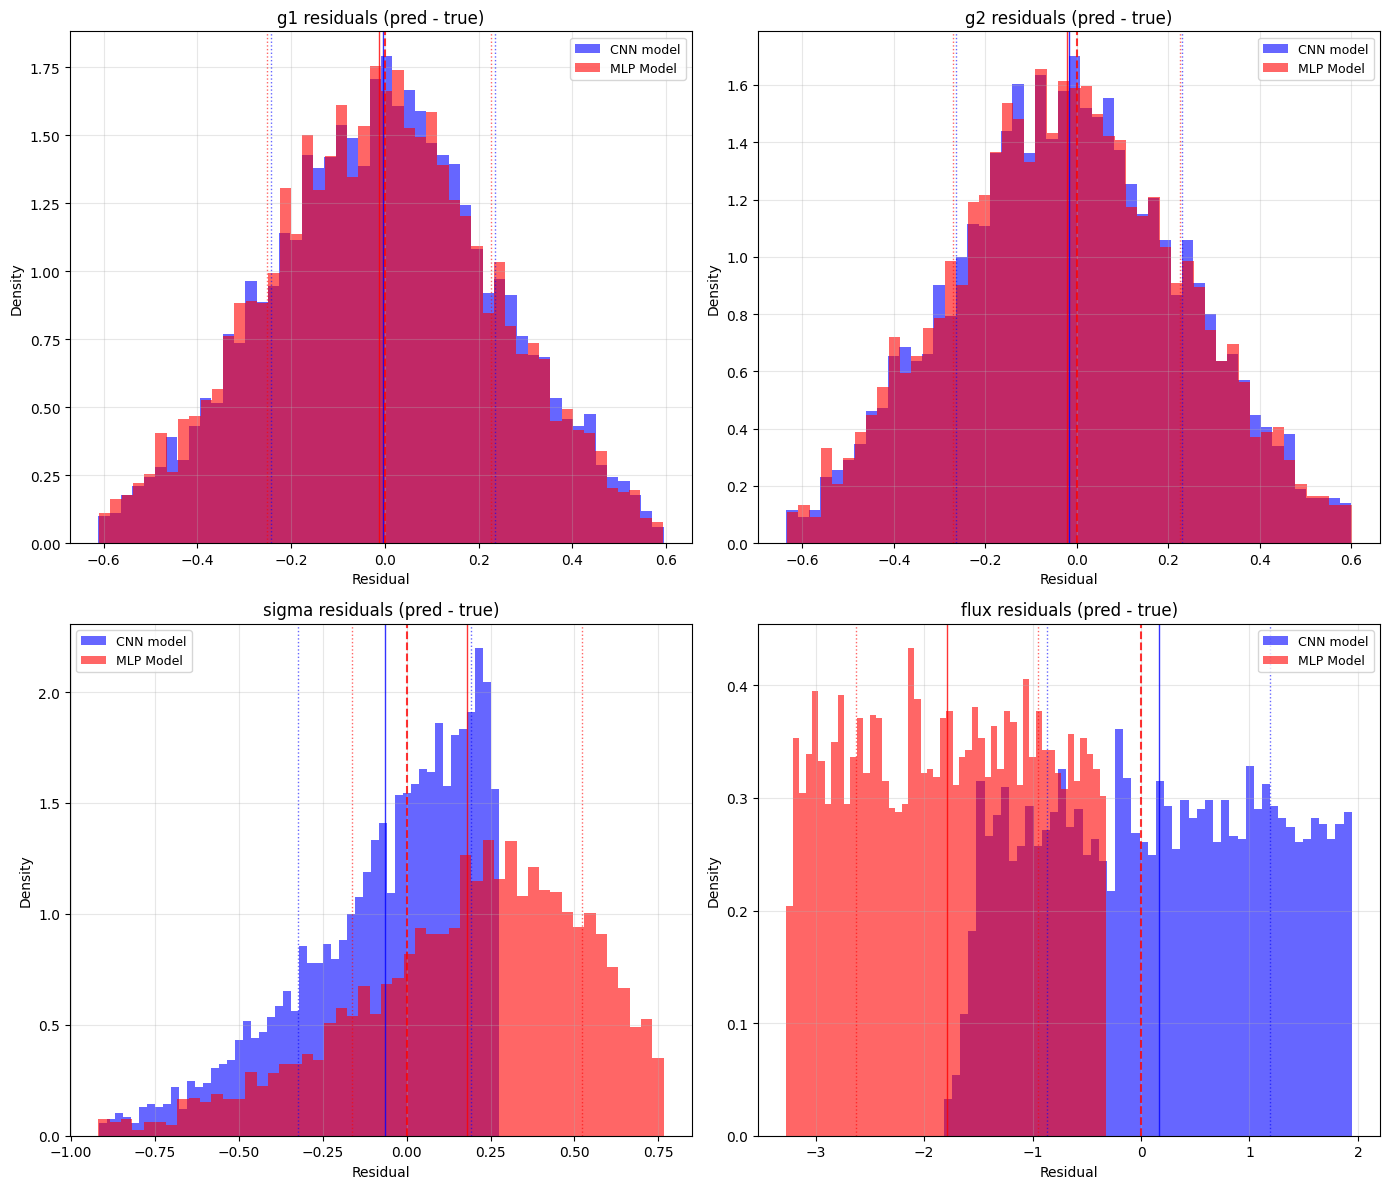

---
Multi-model benchmark complete!
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md


In [9]:
with experiment_section("Residuals Comparison Plots"):
    # Compute residuals for all models
    residuals_data = {}
    for model_name, result in all_results.items():
        preds = result['preds']
        residuals_data[model_name] = {
            "g1": preds[:, 0] - test_labels[:, 0],
            "g2": preds[:, 1] - test_labels[:, 1], 
            "sigma": preds[:, 2] - test_labels[:, 2],
            "flux": preds[:, 3] - test_labels[:, 3],
            "result": result
        }

    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    bins = 50

    for ax, param in zip(axs.flat, ["g1", "g2", "sigma", "flux"]):
        # Collect all residuals for this parameter to determine clipping
        all_residuals = []
        for model_name, model_residuals in residuals_data.items():
            all_residuals.extend(model_residuals[param])
    
        # Clip extremes to focus on the bulk distribution
        clip_min = np.percentile(all_residuals, 1)
        clip_max = np.percentile(all_residuals, 99)

        # Plot histograms for each model
        for model_name, model_residuals in residuals_data.items():
            residuals = model_residuals[param]
            result = model_residuals["result"]
            
            # Clip residuals
            residuals_clipped = residuals[(residuals >= clip_min) & (residuals <= clip_max)]
            
            if result['type'] == 'ngmix':
                color = 'green'
                label = model_name
            else:
                color = result['config'].color
                label = model_name
            
            ax.hist(residuals_clipped, bins=bins, alpha=0.6, label=label, 
                   color=color, density=True)
            
            # Add mean ± std lines
            mean = np.mean(residuals_clipped)
            std = np.std(residuals_clipped)
            ax.axvline(mean, color=color, linestyle='-', linewidth=1, alpha=0.8)
            ax.axvline(mean + std, color=color, linestyle=':', linewidth=1, alpha=0.6)
            ax.axvline(mean - std, color=color, linestyle=':', linewidth=1, alpha=0.6)
        
        ax.axvline(0, color='red', linestyle='--', alpha=0.8)
        
        # Labels
        ax.set_title(f"{param} residuals (pred - true)")
        ax.set_xlabel("Residual")
        ax.set_ylabel("Density")
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save plot and show
    save_plot("residuals_comparison.png")
    plt.show()

log_print("Multi-model benchmark complete!", level="HEADER")